<a href="https://colab.research.google.com/github/pysr1/medium/blob/master/wordVec_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intial Remarks:

* h2o is a very powerful machine learning package that is ready for production out of the box (barreries included as we like to call it)

* The python h2o package sends requests to an h2o cluster using REST

* h20 is far easier to use than sklearn

## Install h2o

In [2]:
%%bash

apt-get install default-jre
pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Reading package lists...
Building dependency tree...
Reading state information...
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
  Created wheel for h2o: filename=h2o-3.26.0.6-py2.py3-none-any.whl size=123690782 sha256=1a250980a1e77d6f956119518de2f44eefa98fa76366486ffee198394e1ab709
  Stored in directory: /root/.cache/pip/wheels/eb/1a/72/252857fc093eaad70a7f91ddbcabf1dafd38fb5e6c02bcf9b3
Successfully built h2o


## Import packages:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from h2o.estimators.word2vec import H2OWord2vecEstimator
import h2o
from nltk.corpus import stopwords 
import nltk
import string
nltk.download('stopwords')
h2o.init(nthreads = -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp36rnsn6h
  JVM stdout: /tmp/tmp36rnsn6h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp36rnsn6h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.6
H2O cluster version age:    5 days
H2O cluster name:           H2O_from_python_unknownUser_8nxfba
H2O cluster total nodes:    1
H2O cluster free memory:    3 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.6.8 final
--------------------------  ------------------------------------------------------------------

## functions :

In [0]:
STOP_WORDS = stopwords.words('english')
add_stop_words = ['data', 'ai']
punctauation = string.punctuation
_ = [STOP_WORDS.append(word) for word in add_stop_words]
[STOP_WORDS.append(punc) for punc in punctauation]
#[STOP_WORDS.append(number) for number in range(1000)]

def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words
  
def predict(job_title,w2v, model):
    words = tokenize(h2o.H2OFrame(job_title).ascharacter())
    job_title_vec = w2v.transform(words, aggregate_method="AVERAGE")
    print(model.predict(test_data=job_title_vec))

In [5]:
medium = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-12-04/medium_datasci.csv'
medium_df = pd.read_csv(medium).drop('x1', 1)    
medium_df = medium_df[~medium_df['title'].isna()]
medium_df['subtitle'] = medium_df['subtitle'].fillna("")
medium_df['publication'] = medium_df['publication'].fillna("")
medium_df['text'] = medium_df['title'] + " " + medium_df['subtitle'] + " " + medium_df['publication']
medium_hdf = h2o.H2OFrame(medium_df)


Parse progress: |█████████████████████████████████████████████████████████| 100%


## Look at the first few rows of data:

In [6]:
medium_df.head(2)

title  ...                                               text
0  Online Animation: Mixamo vs Norah AI  ...  Online Animation: Mixamo vs Norah AI Online an...
1                                A.I. ?  ...                                           A.I. ?  

[2 rows x 21 columns]

## Tokenize and Train Word2Vec:

In [7]:
words = tokenize(medium_hdf['text'])
w2v_model = H2OWord2vecEstimator(sent_sample_rate = 0.0, epochs = 50)
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


## Test what the model has found:

In [8]:
w2v_model.find_synonyms("decision", count = 5)

OrderedDict([('trees', 0.6957622766494751),
             ('tree', 0.682325005531311),
             ('making', 0.6700283288955688),
             ('decisions', 0.6052817106246948),
             ('algorithm', 0.5037594437599182)])

In [9]:
w2v_model.find_synonyms("random", count = 5)

OrderedDict([('forest', 0.7944483757019043),
             ('forests', 0.7705836296081543),
             ('trees', 0.635991632938385),
             ('tree', 0.5875793695449829),
             ('ensemble', 0.5634753108024597)])

In [10]:
w2v_model.find_synonyms("plotly", count = 5)

OrderedDict([('js', 0.5801777243614197),
             ('dash', 0.5623370409011841),
             ('libraries', 0.5397388935089111),
             ('charts', 0.5275946855545044),
             ('library', 0.5265166163444519)])

Nothing should be a syoymms of a blank space lets check this,

In [11]:
w2v_model.find_synonyms(" ", count = 5)

OrderedDict()

# Cluster the Data:

In [12]:
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator


vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

# Train with the Power pca_method
medium_pca = H2OPrincipalComponentAnalysisEstimator(k = 10, transform = "STANDARDIZE", pca_method="Power",
                   use_all_factor_levels=True, impute_missing=True)
medium_pca.train(x=vecs.columns, training_frame=vecs)

vecs = medium_pca.predict(vecs)

#hdf = hdf.cbind(PCS)

pca Model Build progress: |███████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%


In [13]:
from h2o.estimators.kmeans import H2OKMeansEstimator



results = [H2OKMeansEstimator(k=clusters, init="Random", seed=2, standardize=True) for clusters in range(2,30)]
for estimator in results:
    estimator.train(x=vecs.names, training_frame = vecs)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress:

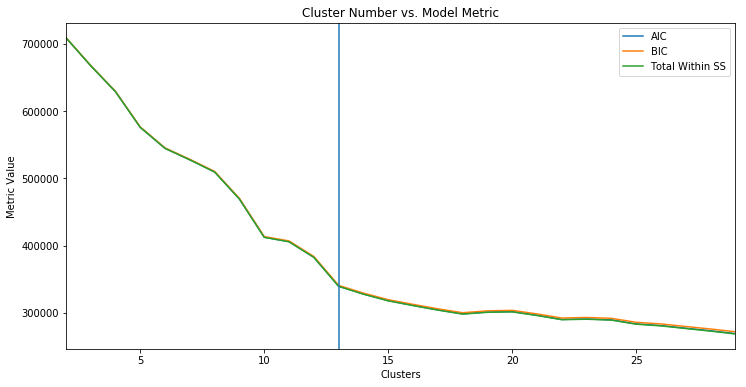

In [18]:
import math

def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}
  
diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
diagnostics.set_index('Clusters', inplace=True)


diagnostics.plot(kind='line', figsize = (12, 6))
plt.title('Cluster Number vs. Model Metric')
plt.axvline(13)
plt.ylabel('Metric Value')
plt.show()

In [19]:
clusters = 13
predicted = results[clusters-2].predict(vecs)
vecs['Cluster'] = predicted["predict"]

kmeans prediction progress: |█████████████████████████████████████████████| 100%


In [22]:
import plotly.express as px
model_df = vecs.as_data_frame()
model_df['title'] = medium_df['title']
model_df['Cluster'] = model_df['Cluster'].astype('object')
fig = px.scatter_3d(model_df, x="PC1", y="PC2", z="PC3", color = 'Cluster', hover_name='title')
fig.show()

In [0]:
medium_df.isna().sum()

In [0]:
len(medium_df)

In [0]:
medium_df['prediceted'] =  predicted["predict"].as_data_frame().astype('int')

In [0]:
medium_df['prediceted'].isna().sum()

In [0]:
medium_df.head()

In [0]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet') 


lemmatizer = WordNetLemmatizer()
medium_df['title'] = [line.lower() for line in medium_df['title']]
medium_df['title'] = [lemmatizer.lemmatize(line) for line in medium_df['title']]
filtered = medium_df[medium_df['Predicted'] == 2].copy() 
words = filtered['title'].str.split(expand=True).stack().value_counts()
words[~words.index.isin(STOP_WORDS)].head(2)

In [0]:
medium_df['words'] = doc.lines.str.strip().str.split('[\W_]+')
doc.head()

In [0]:
medium_df.groupby('Predicted').head()[['title', 'subtitle', 'publication', 'Predicted']]

In [0]:
medium_df.head()

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]')
tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

In [0]:
counts = (medium_df['Predicted'].as_data_frame()['Predicted'].value_counts()) / len(medium_df)
plt.figure(figsize = (14, 8))
counts.plot(kind = 'barh')
plt.title('Percent in Each Cluster')
plt.xlabel('percent')